1875
epoch: 0, loss: 0.2027189994096756


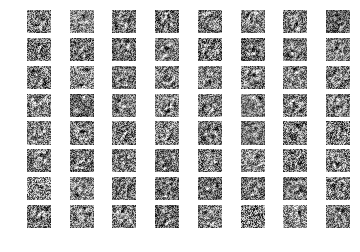

epoch: 1, loss: 0.1499132194042206


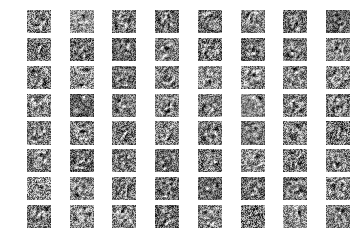

epoch: 2, loss: 0.137463272301356


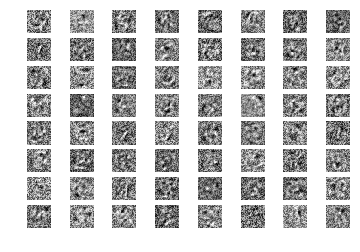

epoch: 3, loss: 0.1303875197172165


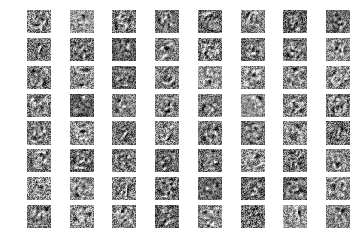

epoch: 4, loss: 0.12559487893184026


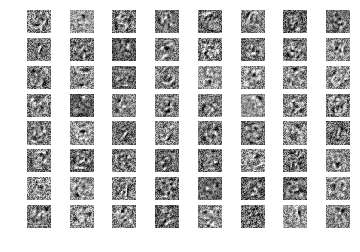

epoch: 5, loss: 0.12193676057656606


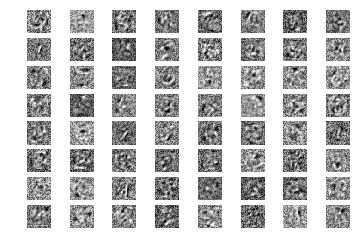

epoch: 6, loss: 0.11899728174606959


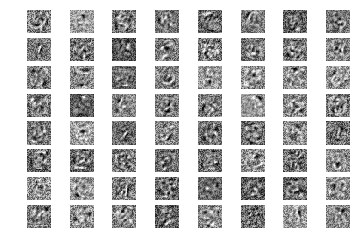

epoch: 7, loss: 0.1163648271282514


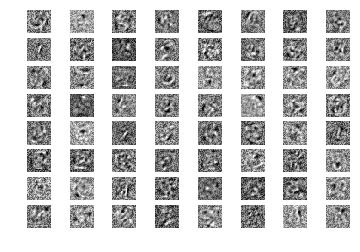

epoch: 8, loss: 0.1143170738140742


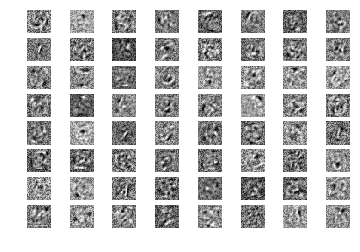

epoch: 9, loss: 0.11277000781297684


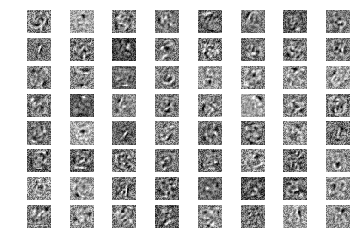

In [3]:
%matplotlib notebook
from matplotlib import pyplot
import torch
# from torch_rbm import BernoulliRBM
from torchvision import transforms
from torchvision.datasets import MNIST

%matplotlib inline
def show_images(images, cols = 1, titles = None):
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = pyplot.figure()
    rows = n_images // cols
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, rows, n + 1)
        if image.ndim == 2:
            pyplot.gray()
        pyplot.imshow(image)
        pyplot.axis('off')
        # a.set_title(title)
    # fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    pyplot.show()

    
class BernoulliRBM(torch.nn.Module):
    """Bernouli Restricted Boltzmann Machine
    http://deeplearning.net/tutorial/rbm.html
    """
    def __init__(self, n_visible, n_hidden):
        super().__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.weight = torch.nn.Parameter(torch.Tensor(self.n_visible, self.n_hidden))
        self.vbias = torch.nn.Parameter(torch.Tensor(self.n_visible))
        self.hbias = torch.nn.Parameter(torch.Tensor(self.n_hidden))
        self.reset_parameters()

    def plot_weight(self, n=64, rows=8):
        show_images(model.weight.t()[:n].view(n, 28, 28).data.numpy(), rows)
        
    def forward(self, v):
        return torch.addmm(1, self.hbias, 1, v, self.weight)

    def reverse(self, h):
        return torch.addmm(1, self.vbias, 1, h, self.weight.t())

    def reset_parameters(self):
        a = 4.0 * ((6.0 / (self.n_hidden + self.n_visible)) ** 0.5)
        self.weight.data.uniform_(-a, a)
        self.hbias.data.zero_()
        self.vbias.data.zero_()

    def sample(self, input):
        return torch.bernoulli(torch.sigmoid(input))

    def free_energy(self, v):
        vterm = v.mv(self.vbias)
        hterm = torch.log(1 + self.forward(v).exp()).sum(1)
        return -hterm - vterm

    def contrastive_divergence(self, v, h_sample=None, n_iter=1):
        with torch.no_grad():
            if h_sample is None:
                h_sample = self.sample(self.forward(v))
            for k in range(n_iter):
                pre_v = self.reverse(h_sample)
                v_sample = self.sample(pre_v)
                h_sample = self.sample(self.forward(v_sample))
            ce = torch.nn.functional.binary_cross_entropy(torch.sigmoid(pre_v), v)
        loss = torch.mean(self.free_energy(v)) - torch.mean(self.free_energy(v_sample))
        return loss, h_sample, ce


# config
n_batch = 32
n_epoch = 10
n_hidden = 500
percistent = False
n_gibbs = 3
lr = 0.01

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_set = MNIST('./data', train=True, download=True, transform=trans)
test_set = MNIST('./data', train=False, download=True, transform=trans)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=n_batch, shuffle=False)
n_input = train_set[0][0].nelement()

model = BernoulliRBM(n_input, n_hidden)
optim = torch.optim.SGD(model.parameters(), lr)
print(len(train_loader))
for e in range(n_epoch):
    sum_loss = 0
    hs = None
    for i, (x, t) in enumerate(train_loader, 1):
        x = (x > 0).float()
        model.zero_grad()
        loss, hs, ce = model.contrastive_divergence(x.view(-1, n_input), hs, n_gibbs)
        if not percistent:
            hs = None
        loss.backward()
        optim.step()
        sum_loss += ce.item()
    print("epoch: {}, loss: {}".format(e, sum_loss / len(train_loader)))
    model.plot_weight()

input


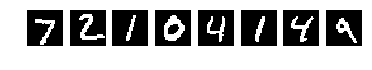

reconstruct


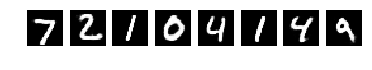

In [40]:
xs = []
rs = []
for i in range(8):
    x = (test_set[i][0][0] > 0).float()
    with torch.no_grad():
        rx = torch.sigmoid(model.reverse(torch.sigmoid(model.forward(x.view(1, -1)))))
    xs.append(x.numpy())
    rs.append(rx.view(28, 28).numpy())

print("input")
show_images(xs)
print("reconstruct")
show_images(rs)